# <center> Features on detections </center>

## Importing libraries

In [1]:
import math
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import seaborn as sns

## Defining functions

In [2]:
def dist(a,b):
    x1 = a[0]
    y1 = a[1]
    x2 = b[:,0]
    y2 = b[:,1]
    x1 = x1*np.ones(x2.shape[0])
    y1 = y1*np.ones(x2.shape[0])
    d = np.power(np.power(x1-x2,2)+np.power(y1-y2,2),0.5)
    return d

def average(array):
    if array.shape[0]==0:
        avg = 0
    else:
        avg = sum(array) / array.shape[0]
    return avg

## Loading variables

In [3]:
corners = np.load('../tables/train_corners_array.npy')
scores = np.load('../tables/train_scores_array.npy')
nms_corners = np.load('../tables/train_detection_corners_nms.npy')
corners_groundtruth = np.load('../tables/train_corners_groundtruth.npy')
iou_nms = np.load('../tables/train_iou_nms.npy')

In [4]:
print(corners.shape)
print(scores.shape)
print(nms_corners.shape)

(374604, 4)
(374604, 1)
(3536, 4)


## Computing TP, FP vectors with their corners

In [5]:
print(f'iou_nms is the intersection over the union of the groudtruth with the detections. \n\
It has on the y-axis {iou_nms.shape[0]}\
 values and on the x-axis {iou_nms.shape[1]} and its shape is {iou_nms.shape}.')
print(f'nms_corners is an array containing the coordinates of all the {nms_corners.shape[0]} detections.')

iou_nms is the intersection over the union of the groudtruth with the detections. 
It has on the y-axis 3147 values and on the x-axis 3536 and its shape is (3147, 3536).
nms_corners is an array containing the coordinates of all the 3536 detections.


In [6]:
tp = []
fp = []
tp_corners = []
fp_corners = []
fp_threshold = 0.15

for i in range(iou_nms.shape[1]): 
    
    max_iou = max(iou_nms[:,i])
    if max_iou < fp_threshold:
        tp.append(0)
        fp.append(1)
        fp_corners.append(nms_corners[i,:])
    else:
        tp.append(1)
        tp_corners.append(nms_corners[i,:])
        fp.append(0)
    
tp = np.asarray(tp)
fp = np.asarray(fp)
tp_corners = np.asarray(tp_corners)
fp_corners = np.asarray(fp_corners)

np.save('../tables/train_tp.npy', tp)
np.save('../tables/train_fp.npy', fp)
np.save('../tables/train_tp_corners.npy', tp_corners)
np.save('../tables/train_fp_corners.npy', fp_corners)

In [7]:
iou_nms.shape[1]

3536

## Computing features for each detection

In [8]:
radius = 35

### Defining vector variables for logical indexation

In [9]:
threshold1 = 0.5

scores1 = scores[scores>threshold1]
corners1 = corners[np.where(scores>threshold1)[0]]

threshold2 = 0.996

scores2 = scores[scores>threshold2]
corners2 = corners[np.where(scores>threshold2)[0]]

### On each neighbour

In [10]:
avg_score_list = []
neighbor_nb_list = []
std_score_list = []
avg_score_list_excl = []
neighbor_nb_list_excl = []
std_score_list_excl = []

for i in range(nms_corners.shape[0]):
    distance_i = dist(nms_corners[i], corners)
    avg_score = average(scores[distance_i < radius])
    avg_score_list.append(avg_score)
    neighbor_nb_list.append((distance_i < radius).sum())
    std_score_list.append(np.std(scores[distance_i < radius]))
    
    scores_excl = np.delete(scores,i,0)
    corners_excl = np.delete(corners,i,0)
    distance_i = dist(nms_corners[i], corners_excl)
    avg_score = average(scores_excl[distance_i < radius])
    avg_score_list_excl.append(avg_score)
    neighbor_nb_list_excl.append((distance_i < radius).sum())
    std_score_list_excl.append(np.std(scores_excl[distance_i < radius]))

### On each neighbour after threshold 1

In [11]:
# threshold 1
avg_score1_list = []
neighbor_nb1_list = []
std_score1_list = []
avg_score1_list_excl = []
neighbor_nb1_list_excl = []
std_score1_list_excl = []

for i in range(nms_corners.shape[0]):
    distance_i = dist(nms_corners[i], corners1)
    avg_score = average(scores1[distance_i < radius])
    avg_score1_list.append(avg_score)
    neighbor_nb1_list.append((distance_i < radius).sum())
    std_score1_list.append(np.std(scores1[distance_i < radius]))
    
    scores1_excl = np.delete(scores1,i,0)
    corners1_excl = np.delete(corners1,i,0)
    distance_i = dist(nms_corners[i], corners1_excl)
    avg_score = average(scores1_excl[distance_i < radius])
    avg_score1_list_excl.append(avg_score)
    neighbor_nb1_list_excl.append((distance_i < radius).sum())
    std_score1_list_excl.append(np.std(scores1_excl[distance_i < radius]))

### On each neighbour after threshold 2

In [12]:
# threshold 2
avg_score2_list = []
neighbor_nb2_list = []
std_score2_list = []
avg_score2_list_excl = []
neighbor_nb2_list_excl = []
std_score2_list_excl = []

for i in range(nms_corners.shape[0]):
    distance_i = dist(nms_corners[i], corners2)
    avg_score = average(scores2[distance_i < radius])
    avg_score2_list.append(avg_score)
    neighbor_nb2_list.append((distance_i < radius).sum())
    std_score2_list.append(np.std(scores2[distance_i < radius]))
    
    scores2_excl = np.delete(scores1,i,0)
    corners2_excl = np.delete(corners1,i,0)
    distance_i = dist(nms_corners[i], corners2_excl)
    avg_score = average(scores2_excl[distance_i < radius])
    avg_score2_list_excl.append(avg_score)
    neighbor_nb2_list_excl.append((distance_i < radius).sum())
    std_score2_list_excl.append(np.std(scores2_excl[distance_i < radius]))

C:\Users\diego\anaconda3\envs\palms_nvidia\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\diego\anaconda3\envs\palms_nvidia\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\diego\anaconda3\envs\palms_nvidia\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### On each neighbour after thresholds and NMS

In [13]:
# nms
avg_score3_list = []
neighbor_nb3_list = []
std_score3_list = []

for i in range(nms_corners.shape[0]):
    distance_i = dist(nms_corners[i], np.delete(nms_corners,i, axis = 0))
    avg_score = average(np.delete(nms_corners,i, axis = 0)[distance_i < radius])
    avg_score3_list.append(avg_score)
    neighbor_nb3_list.append((distance_i < radius).sum())

## Transforming lists of features into arrays and reshaping

In [14]:
avg_score_array = np.asarray(avg_score_list)
avg_score1_array = np.asarray(avg_score1_list)
avg_score2_array = np.asarray(avg_score2_list)
avg_score3_array = np.asarray(avg_score3_list)

avg_score_array_excl = np.asarray(avg_score_list_excl)
avg_score1_array_excl = np.asarray(avg_score1_list_excl)
avg_score2_array_excl = np.asarray(avg_score2_list_excl)

neighbor_nb_array = np.asarray(neighbor_nb_list)
neighbor_nb1_array = np.asarray(neighbor_nb1_list)
neighbor_nb2_array = np.asarray(neighbor_nb2_list)
neighbor_nb3_array = np.asarray(neighbor_nb3_list)

neighbor_nb_array_excl = np.asarray(neighbor_nb_list_excl)
neighbor_nb1_array_excl = np.asarray(neighbor_nb1_list_excl)
neighbor_nb2_array_excl = np.asarray(neighbor_nb2_list_excl)

std_score_array = np.asarray(std_score_list)
std_score1_array = np.asarray(std_score1_list)
std_score2_array = np.asarray(std_score2_list)

std_score_array_excl = np.asarray(std_score_list_excl)
std_score1_array_excl = np.asarray(std_score1_list_excl)
std_score2_array_excl = np.asarray(std_score2_list_excl)

avg_score_array = avg_score_array.reshape(-1, 1)
avg_score1_array = avg_score1_array.reshape(-1, 1)
avg_score2_array = avg_score2_array.reshape(-1, 1)
avg_score3_array = avg_score3_array.reshape(-1, 1)

avg_score_array_excl = avg_score_array_excl.reshape(-1, 1)
avg_score1_array_excl = avg_score1_array_excl.reshape(-1, 1)
avg_score2_array_excl = avg_score2_array_excl.reshape(-1, 1)

neighbor_nb1_array = neighbor_nb1_array.reshape(-1, 1)
neighbor_nb2_array = neighbor_nb2_array.reshape(-1, 1)
neighbor_nb3_array = neighbor_nb3_array.reshape(-1, 1)

neighbor_nb1_array_excl = neighbor_nb1_array_excl.reshape(-1, 1)
neighbor_nb2_array_excl = neighbor_nb2_array_excl.reshape(-1, 1)

std_score_array = std_score_array.reshape(-1, 1)
std_score1_array = std_score1_array.reshape(-1, 1)
std_score2_array = std_score2_array.reshape(-1, 1)

std_score_array_excl = std_score_array_excl.reshape(-1, 1)
std_score1_array_excl = std_score1_array_excl.reshape(-1, 1)
std_score2_array_excl = std_score2_array_excl.reshape(-1, 1)

In [15]:
#np.save('../tables/avg_score.npy', avg_score_array)

## Plotting statistics on features

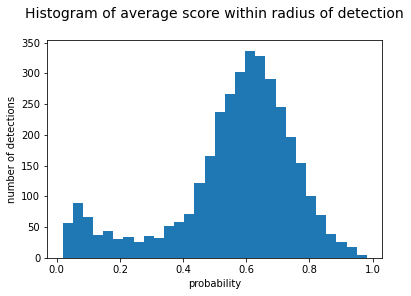

The number of values bellow a score of 0.9 is 3487.


In [16]:
fig, ax = plt.subplots()

ax.hist(avg_score_array, bins = 30, align='left')
ax.set_xlabel('probability')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of average score within radius of detection\n', fontsize=14)

plt.show()

print(f'The number of values bellow a score of 0.9 is {(avg_score_array < 0.9).sum()}.')

The skewness of this graph can be explained by the fact that the nearby windows around the detection have also high probabilities to be a coconut palm. If the radius of windows selected to do the average over is increased, the skewness of the graph might be reduced and the values might be more distributed into other bins. 

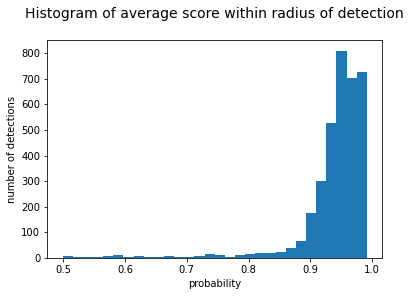

The number of values bellow a score of 0.9 is 283.


In [17]:
fig, ax = plt.subplots()

ax.hist(avg_score1_array, bins = 30, align='left')
ax.set_xlabel('probability')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of average score within radius of detection\n', fontsize=14)

plt.show()

print(f'The number of values bellow a score of 0.9 is {(avg_score1_array < 0.9).sum()}.')

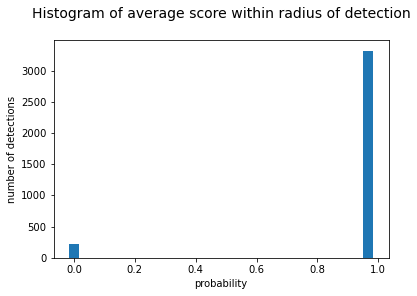

The number of values bellow a score of 0.9 is 215.


In [18]:
fig, ax = plt.subplots()

ax.hist(avg_score2_array, bins = 30, align='left')
ax.set_xlabel('probability')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of average score within radius of detection\n', fontsize=14)

plt.show()

print(f'The number of values bellow a score of 0.9 is {(avg_score2_array < 0.9).sum()}.')

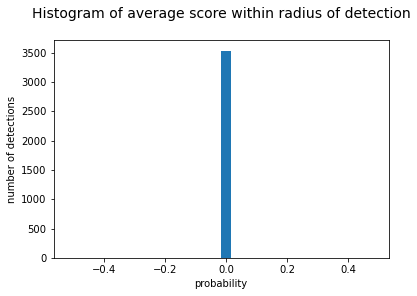

The number of values bellow a score of 0.9 is 3536.


In [19]:
fig, ax = plt.subplots()

ax.hist(avg_score3_array, bins = 30, align='left')
ax.set_xlabel('probability')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of average score within radius of detection\n', fontsize=14)

plt.show()

print(f'The number of values bellow a score of 0.9 is {(avg_score3_array < 0.9).sum()}.')

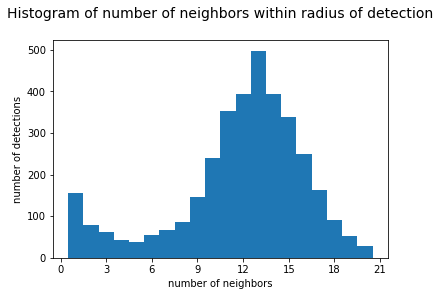

In [20]:
fig, ax = plt.subplots()

ax.hist(neighbor_nb1_array, bins = 20, align='left')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of number of neighbors within radius of detection\n', fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

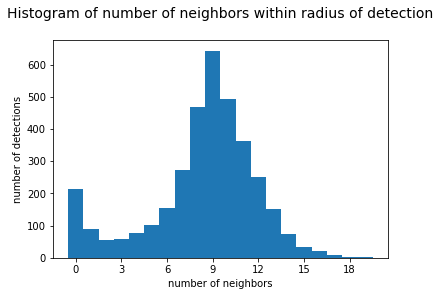

In [21]:
fig, ax = plt.subplots()

ax.hist(neighbor_nb2_array, bins = 20, align='left')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of number of neighbors within radius of detection\n', fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

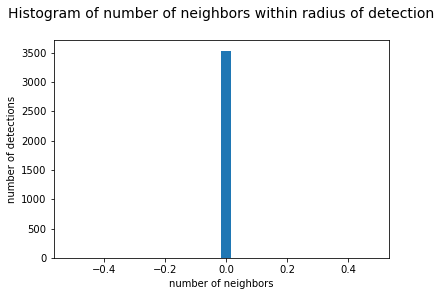

In [22]:
fig, ax = plt.subplots()

ax.hist(neighbor_nb3_array, bins = 30, align='left')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of number of neighbors within radius of detection\n', fontsize=14)

plt.show()

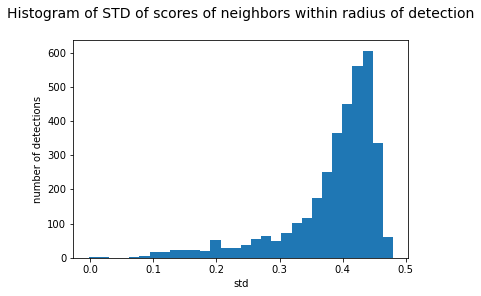

In [23]:
fig, ax = plt.subplots()

ax.hist(std_score_array, bins = 30, align='left')
ax.set_xlabel('std')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of STD of scores of neighbors within radius of detection\n', fontsize=14)

plt.show()

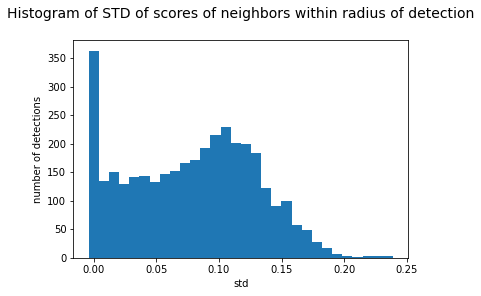

In [24]:
fig, ax = plt.subplots()

ax.hist(std_score1_array, bins = 30, align='left')
ax.set_xlabel('std')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of STD of scores of neighbors within radius of detection\n', fontsize=14)

plt.show()

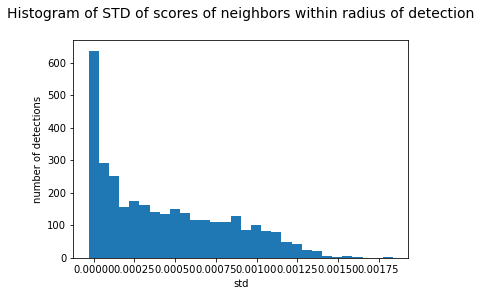

In [25]:
fig, ax = plt.subplots()

ax.hist(std_score2_array, bins = 30, align='left')
ax.set_xlabel('std')
ax.set_ylabel('number of detections')
ax.set_title('Histogram of STD of scores of neighbors within radius of detection\n', fontsize=14)

plt.show()

## Preparing train features and labels as arrays

In [26]:
X = np.concatenate((avg_score_array, avg_score1_array, avg_score2_array, neighbor_nb1_array, neighbor_nb2_array, 
                    std_score_array, std_score1_array, std_score2_array), axis=1)
print(X.shape)

(3536, 8)


In [27]:
# std_score_array_excl, std_score1_array_excl, std_score2_array_excl, neighbor_nb2_array_excl

In [28]:
y = fp
print(y.shape)

(3536,)


In [29]:
print(np.any(np.isnan(X)))
X = np.nan_to_num(X)
print(np.any(np.isnan(X)))

True
False


## Data visualization

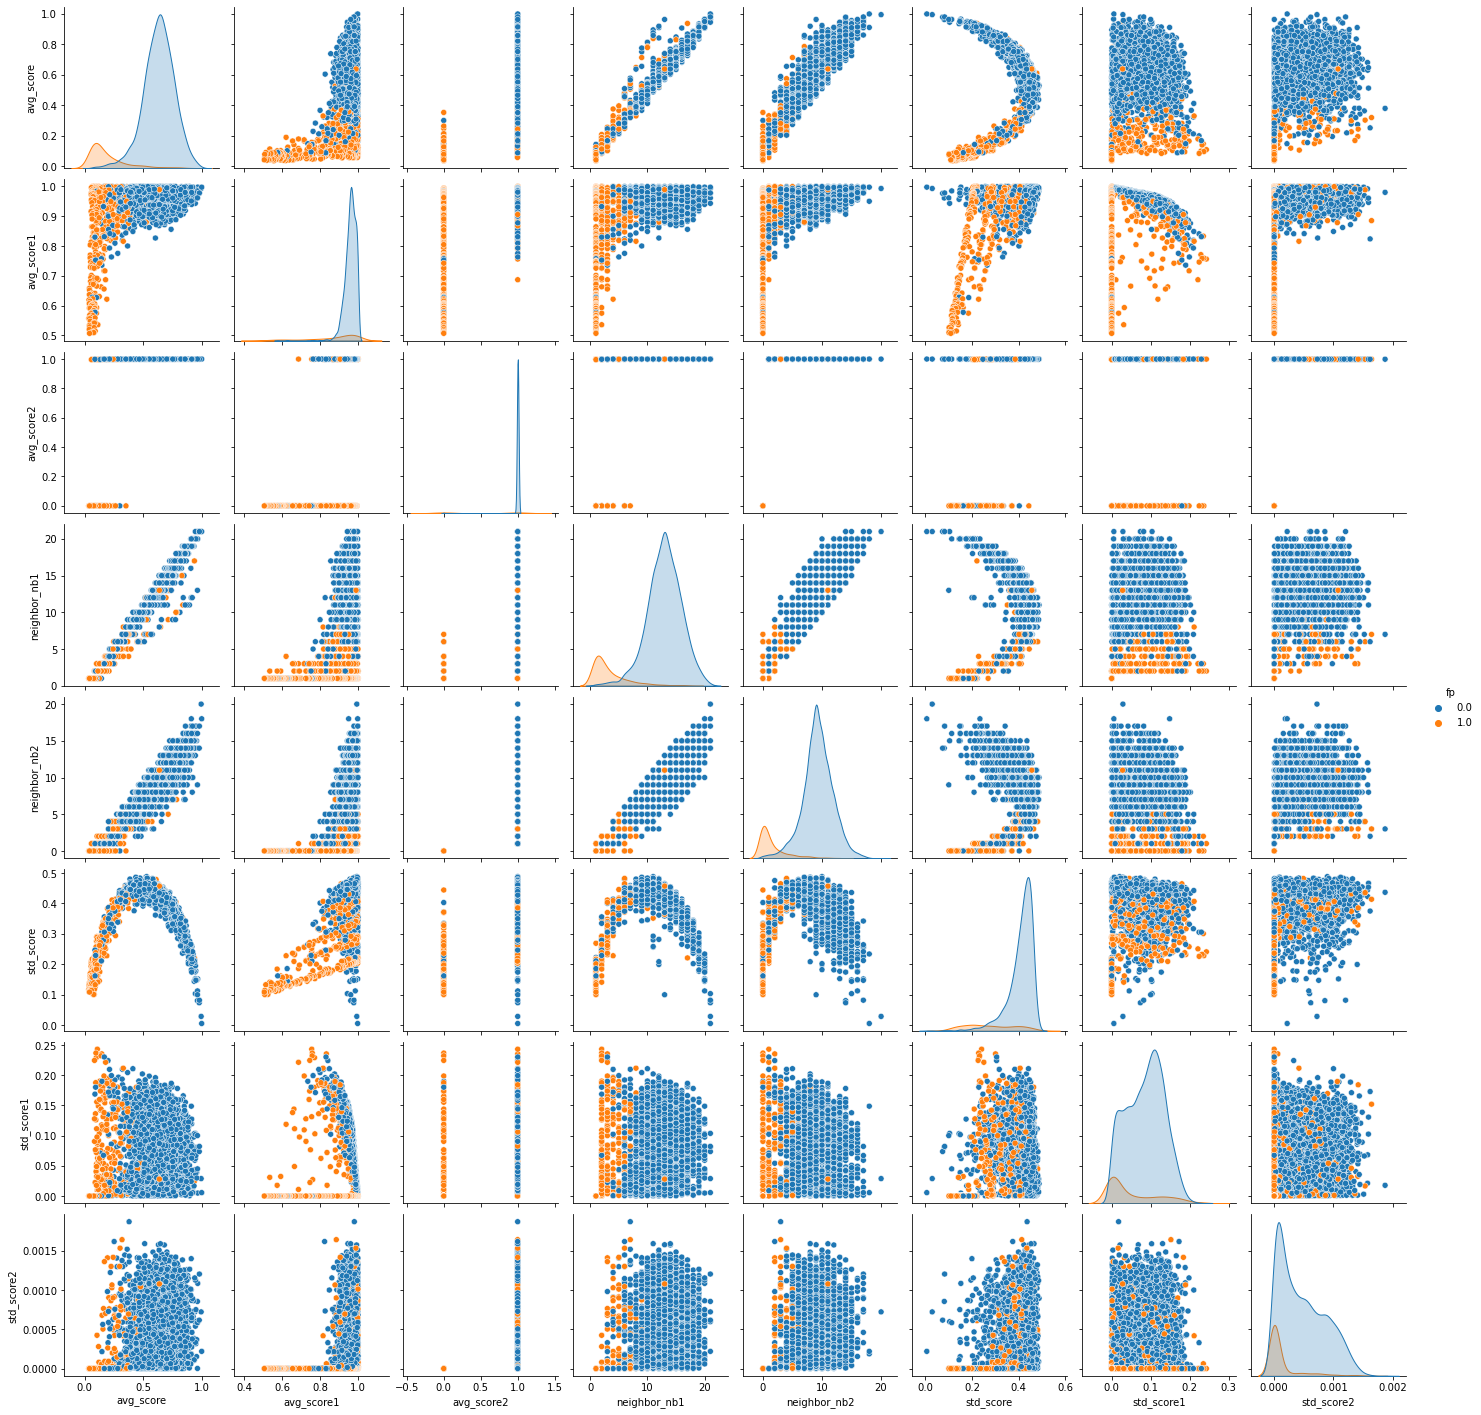

In [63]:
df = pd.DataFrame(np.concatenate((X,y.reshape(-1, 1)),axis=1), 
                  columns = ['avg_score', 'avg_score1', 'avg_score2', 'neighbor_nb1','neighbor_nb2',
                             'std_score', 'std_score1', 'std_score2','fp'])

sns.pairplot(df, hue = 'fp') # also try "profiling"
plt.show()

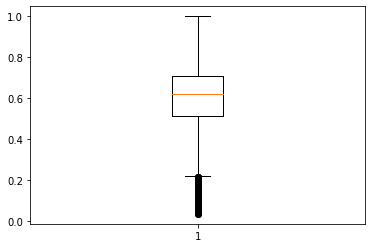

In [31]:
plt.figure()
plt.boxplot(X[:,0])
plt.show()

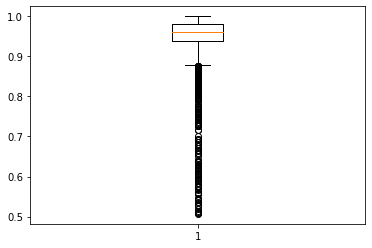

In [32]:
plt.figure()
plt.boxplot(X[:,1])
plt.show()

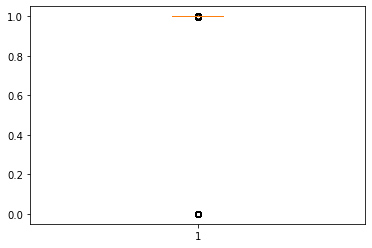

In [33]:
plt.figure()
plt.boxplot(X[:,2])
plt.show()

## Splitting into train and testing set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Scaling training set

In [35]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Training the RF model

In [36]:
clf = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=20)

In [37]:
clf.fit(X_train, y_train)
print("Classifier trained")
error_pred = clf.predict(X_test)
error_prob = clf.predict_proba(X_test)

Classifier trained


## Displaying model metrics

In [38]:
wdw_error_cm = confusion_matrix(y_test, error_pred)
print(wdw_error_cm)

[[1021   14]
 [  22  110]]


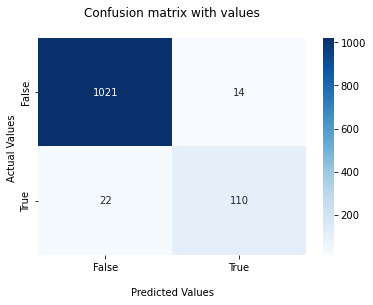

In [39]:
ax = sns.heatmap(wdw_error_cm, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion matrix with values\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [40]:
print(f'\nThe accuracy: {accuracy_score(y_test, error_pred)*100:.2f}%')
print(f'The f1-score: {f1_score(y_test, error_pred)*100:.2f}%')
print(f'The recall: {recall_score(y_test, error_pred)*100:.2f}%')
print(f'The precision: {precision_score(y_test, error_pred)*100:.2f}%')


The accuracy: 96.92%
The f1-score: 85.94%
The recall: 83.33%
The precision: 88.71%


## Grid search for parameter tuning

In [41]:
 ## Cross validation for parameter search
tuned_parameters = [{"n_estimators": [5, 10, 20, 50, 100, 150, 200, 250, 300], "max_depth": [5, 10, 40, 50, 60, 100, None]}]
score_cv = "f1"
clf_cv = GridSearchCV(RandomForestClassifier(random_state=42), tuned_parameters, scoring="%s_macro" % score_cv, cv=3)
clf_cv.fit(X, y)
print("Best parameters set found on development set:")
print(clf_cv.best_params_)

Best parameters set found on development set:
{'max_depth': 5, 'n_estimators': 20}


## Assessing overfitting

### On number of estimators

In [42]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = range(5,305,5)

# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators = i, max_depth = 5)
    
    # fit model on the training dataset
    model.fit(X_train, y_train)
    
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    
    # summarize progress
    #print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

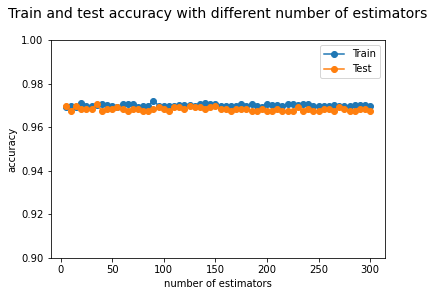

In [43]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.ylim(0.9, 1)
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.title('Train and test accuracy with different number of estimators\n', fontsize=14)
plt.legend()
plt.show()

### On maximum depth

In [44]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = range(1,101)

# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators = 250, max_depth = i)
    
    # fit model on the training dataset
    model.fit(X_train, y_train)
    
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    
    # summarize progress
    #print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

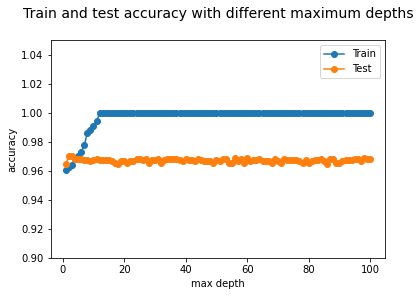

In [45]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.ylim(0.9, 1.05)
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Train and test accuracy with different maximum depths\n', fontsize=14)
plt.legend()
plt.show()

## Feature importance based on mean decrease in impurity

In [46]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

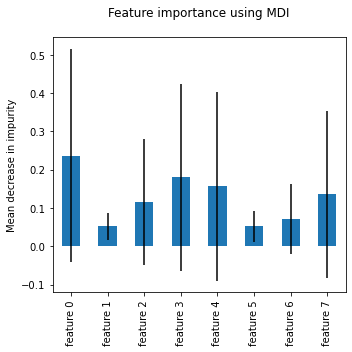

In [48]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(5,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance using MDI\n")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Feature importance based on feature permutation  <br>
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.

In [49]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

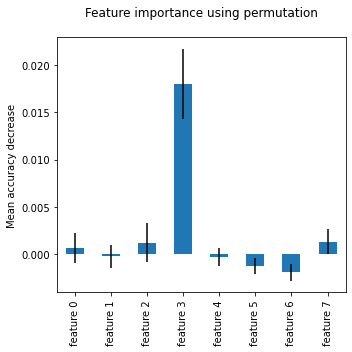

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importance using permutation\n")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()